In [1]:
import requests
import pandas as pd
import io
import warnings
import json
import numpy as np
from time import gmtime
from time import strftime
from pandas.io.excel import ExcelWriter
from datetime import datetime
import os
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.drawing.image import Image


In [2]:
# ПРОПИСЫВАЕМ ЗАПРОС К МЕТРИКЕ 
# номер счетчика клиента в Я.метрике 
id_cab = ????? 
# URL-адрес API Яндекс.Метрики (общ.)
API_URL = ??????.csv
# API_token Яндекс.Метрики 
API_token = ????


In [ ]:
# Выставляем даты - период
date_from = '2025-01-01'
date_to = '2025-02-28'

# Параметры для отчета Посещаемость
params = {
'date1': date_from,
'date2': date_to,
'id': id_cab, # номер счетчика клиента в Я.метрике 
'accuracy': 1,
'attribution': 'lastsign',
'metrics': 'ym:s:users, ym:s:bounceRate, ym:s:pageDepth, ym:s:avgVisitDurationSeconds, ym:s:goalxxxusers', ##цель, где xxx - номер цели, прописанный вразделе Цели Я.метрики (в нашем случае цель - Отправка формы Зарегистрироваться)
'filters': "ym:s:isRobot=='No'" # Роботность - только люди
}

# Параметры для отчета Посещаемость_1
params_attendance_1 = {
'date1': date_from,
'date2': date_to,
'id': id_cab, # номер счетчика клиента в Я.метрике 
'accuracy': 1,
'attribution': 'lastsign',
'metrics': 'ym:s:users, ym:s:goalxxxusers', ##цель, где xxx - номер цели, прописанный вразделе Цели Я.метрики (в нашем случае цель - Отправка формы Зарегистрироваться)
'dimensions': 'ym:s:datePeriodMonth',  # Детализация по месяцам
'group': 'month',
'filters': "ym:s:isRobot=='No'" # Роботность - только люди
#'sort:"ym:s:date"
}

r = requests.get(API_URL, params = params, headers={'Authorization': 'OAuth ' + API_token})
print(r.text)



In [ ]:
# ПРЕОБРАЗОВАНИЕ ОТВЕТА АПИ В ФРЕЙМ ДАННЫХ
if r.status_code == 200:
    df = pd.read_csv(io.StringIO(r.text))
else:
    print("Request failed with status code:", r.status_code)

rc = requests.get(API_URL, params=params_attendance_1, headers={'Authorization': 'OAuth ' + API_token})

print(rc.text)

# ПРЕОБРАЗОВАНИЕ ОТВЕТА АПИ В ФРЕЙМ ДАННЫХ ДЛЯ ATTENDANCE_1
if rc.status_code == 200:
    df_attendance_1 = pd.read_csv(io.StringIO(rc.text)) #Используем rc.text, а не r.text
else:
    print("Request failed with status code:", rc.status_code)
    df_attendance_1 = None  

In [5]:
if df_attendance_1 is not None: # Проверяем, есть ли данные
    if not df_attendance_1.empty: # Переименовываем столбцы
        df_attendance_1.rename(columns={
            'Date interval of visit': 'Период',
            'Users': 'Посетители',
            'Converted users (Отправка формы - Зарегистрироваться)': 'Целевые посетители', #"Converted users (Отправка формы - Зарегистрироваться) Goal 303398209, Reaches
        }, inplace=True)
        # Преобразуем формат для расчета
        df_attendance_1['Целевые посетители'] = pd.to_numeric(df_attendance_1['Целевые посетители'], errors='coerce').fillna(0)
        df_attendance_1['Посетители'] = pd.to_numeric(df_attendance_1['Посетители'], errors='coerce').fillna(0)

        #  Вычисляем конверсию
        df_attendance_1['Конверсия (%)'] = round((df_attendance_1['Целевые посетители'] / df_attendance_1['Посетители']) * 100, 2)

        # Преобразуем столбец 'Период' в дату вида месяц+год
        def extract_month_year(period_str):
            if isinstance(period_str, str):
                try:
                    date_part = period_str.split(' - ')[0] # Разделяем строку по дефису и берем первый элемент
                    date_obj = pd.to_datetime(date_part) # Преобразуем в формат datetime
                    return date_obj.strftime('%B %Y')  # %B - полное название месяца
                except (ValueError, TypeError):
                    return period_str  # Возвращаем исходную строку, если преобразование не удалось
            return period_str

        df_attendance_1['Период'] = df_attendance_1['Период'].apply(extract_month_year)

        # Заменяем Totals and averages на "Итоги"
        df_attendance_1['Период'] = df_attendance_1['Период'].fillna("Всего/Среднее")

        print(df_attendance_1.head(5))
    else:
        print("Нет данных для посещаемости")
else:
    print("Не удалось получить данные по посещаемости")


                Период  Посетители  Целевые посетители  Конверсия (%)
0  Totals and averages       15561                  59           0.38
1         January 2025        7943                  32           0.40
2        February 2025        7786                  27           0.35


In [6]:
##СЕГМЕНТЫ
NEW_VISITORS_FILTER = "ym:s:isNewUser=='Yes'" #Новый посетитель
RETURNING_VISITORS_FILTER = "ym:s:isNewUser=='No'" #Вернувшийся посетитель
AUTHORIZED_USERS_FILTER = "ym:up:paramsLevel1=='UserID'" #Авторизованный посетитель

# Функция для получения данных для сегмента и добавления префикса к столбцам
def get_segment_data(params, segment_name):
    r = requests.get(API_URL, params=params, headers={'Authorization': 'OAuth ' + API_token})

    if r.status_code == 200:
        df = pd.read_csv(io.StringIO(r.text))
        # Добавляем префикс к названиям столбцов (кроме столбца с периодом)
        new_columns = {}
        for col in df.columns:
            if col == 'Date interval of visit':
                new_columns[col] = 'Период'
            else:
                new_columns[col] = f'{col} ({segment_name})'
        df.rename(columns=new_columns, inplace=True)
        return df
    else:
        print(f"Request failed with status code: {r.status_code}")
        return None


In [ ]:
# 1. Новые посетители

params_new = {
'date1': date_from,
'date2': date_to,
'id': id_cab, # номер счетчика клиента в Я.метрике 
'accuracy': 1,
'attribution': 'lastsign',
'metrics': 'ym:s:users, ym:s:bounceRate, ym:s:pageDepth, ym:s:avgVisitDurationSeconds',
'dimensions': 'ym:s:datePeriodMonth',  # Детализация по месяцам
'group': 'month',
'filters': f"ym:s:isRobot=='No' AND {NEW_VISITORS_FILTER}"
}

r_new = requests.get(API_URL, params=params_new, headers={'Authorization': 'OAuth ' + API_token})
print(r_new.text)

# Преобразование ответа API в df для новых посетителей
if r_new.status_code == 200:
    df_new = pd.read_csv(io.StringIO(r_new.text))
else:
    print("Request failed (new visitors) with status code:", r_new.status_code)
    df_new = None

if df_new is not None:  # Проверяем, что df_new не None
    print(df_new.head())  # Выводим первые 5 строк DataFrame для новых посетителей
else:
    print("Не удалось получить данные для новых посетителей.")


In [ ]:
# 1. Вернувшиеся посетители

params_return = {
'date1': date_from,
'date2': date_to,
'id': id_cab, # номер счетчика клиента в Я.метрике 
'accuracy': 1,
'attribution': 'lastsign',
'metrics': 'ym:s:users, ym:s:bounceRate, ym:s:pageDepth, ym:s:avgVisitDurationSeconds',
'dimensions': 'ym:s:datePeriodMonth',  # Детализация по месяцам
'group': 'month',
'filters': f"ym:s:isRobot=='No' AND {RETURNING_VISITORS_FILTER}"
}

r_return = requests.get(API_URL, params=params_return, headers={'Authorization': 'OAuth ' + API_token})
print(r_return.text)

# Преобразование ответа API в df для новых посетителей
if r_return.status_code == 200:
    df_return = pd.read_csv(io.StringIO(r_return.text))
else:
    print("Request failed (new visitors) with status code:", r_return.status_code)
    df_return = None

if df_return is not None:  # Проверяем, что df_new не None
    print(df_return.head())  # Выводим первые 5 строк DataFrame для новых посетителей
else:
    print("Не удалось получить данные для новых посетителей.")


In [ ]:
# 1. Авторизованные посетители

params_auth = {
'date1': date_from,
'date2': date_to,
'id': id_cab, # номер счетчика клиента в Я.метрике 
'accuracy': 1,
'attribution': 'lastsign',
'metrics': 'ym:s:users, ym:s:bounceRate, ym:s:pageDepth, ym:s:avgVisitDurationSeconds',
'dimensions': 'ym:s:datePeriodMonth',  # Детализация по месяцам
'group': 'month',
'filters': f"ym:s:isRobot=='No' AND {AUTHORIZED_USERS_FILTER}"
}

r_auth = requests.get(API_URL, params=params_auth, headers={'Authorization': 'OAuth ' + API_token})
print(r_auth.text)

# Преобразование ответа API в df для новых посетителей
if r_auth.status_code == 200:
    df_auth = pd.read_csv(io.StringIO(r_auth.text))
else:
    print("Request failed (new visitors) with status code:", r_auth.status_code)
    df_auth = None

if df_auth is not None:  # Проверяем, что df_new не None
    print(df_auth.head())  # Выводим первые 5 строк DataFrame для новых посетителей
else:
    print("Не удалось получить данные для новых посетителей.")

In [ ]:
# Соединяем данные сегментов
df_new = get_segment_data(params_new, 'Новые')
df_return = get_segment_data(params_return, 'Вернувшиеся')
df_auth = get_segment_data(params_auth, 'Авторизованные')

merged_df = None

if df_new is not None:
    merged_df = df_new.copy()    
    if df_return is not None:
        merged_df = pd.merge(merged_df, df_return, on='Период', how='left')
    if df_auth is not None:
        merged_df = pd.merge(merged_df, df_auth, on='Период', how='left')

    merged_df.fillna(0, inplace=True)

    # Преобразуем столбец 'Период' в дату вида месяц+год
    def extract_month_year(period_str):
        if isinstance(period_str, str):
            try:
                date_part = period_str.split(' - ')[0]  # Разделяем строку по дефису и берем первый элемент
                date_obj = pd.to_datetime(date_part)  # Преобразуем в формат datetime
                return date_obj.strftime('%B %Y')  # %B - полное название месяца
            except (ValueError, TypeError):
                return period_str  # Возвращаем исходную строку, если преобразование не удалось
        return period_str

    merged_df['Период'] = merged_df['Период'].apply(extract_month_year)
    columns_to_round = [
    'Bounce rate (Новые)', 'Bounce rate (Вернувшиеся)', 'Bounce rate (Авторизованные)',
    'Page depth (Новые)', 'Page depth (Вернувшиеся)', 'Page depth (Авторизованные)'
    ]

    for column in columns_to_round:
        if column in merged_df.columns: # Проверяем, существует ли столбец
            merged_df[column] = merged_df[column].round(2)
    print(merged_df.head())
else:
    print("Нет данных для новых посетителей. Невозможно создать итоговую таблицу.")
    



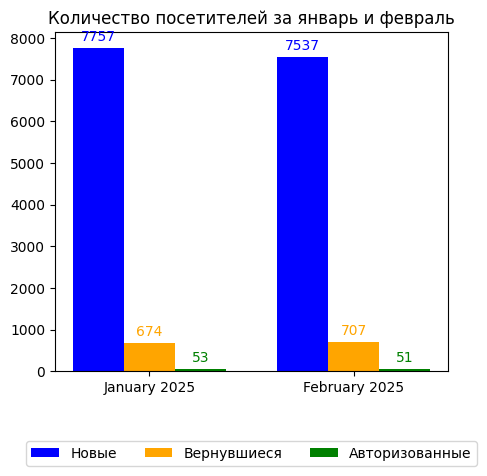

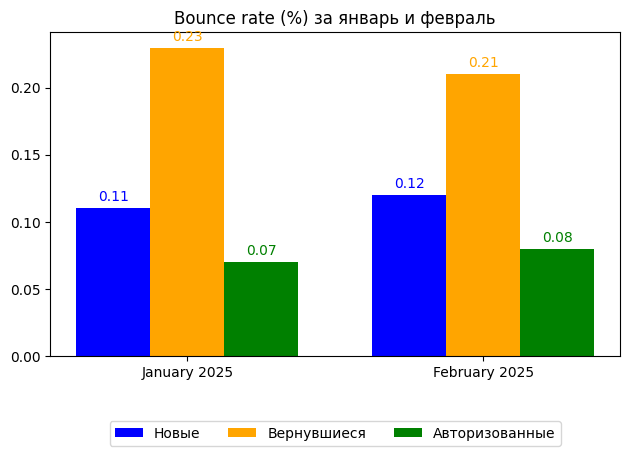

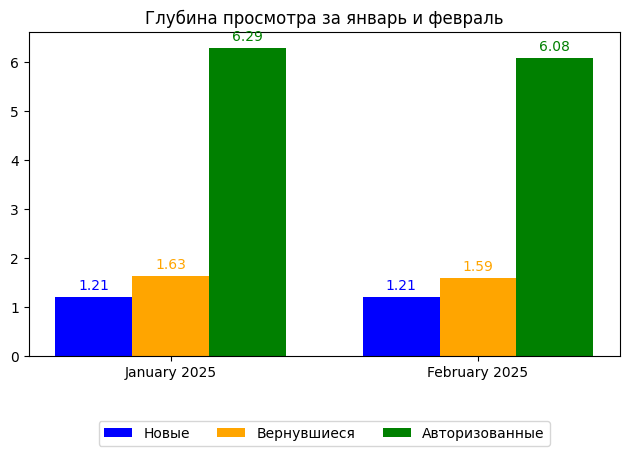

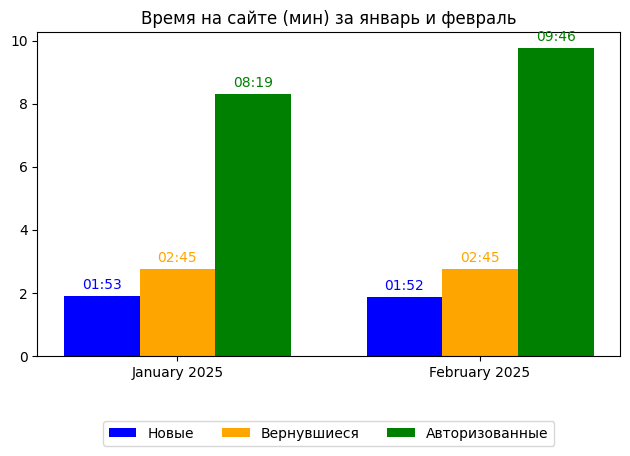

In [ ]:
# ГРАФИКИ
# Фильтруем данные, удаляем строку "Totals and averages"
merged_df_filtered = merged_df[merged_df['Период'] != 'Totals and averages'].copy()
#print(merged_df_filtered.dtypes)
# Время в мин
def time_to_minutes(time_str):
    if isinstance(time_str, str):
        parts = list(map(int, time_str.split(':')))
        return round(parts[0] * 60 + parts[1] + parts[2] / 60, 2) # в минутах
    return np.nan  # если время невалидно, возвращаем NaN

# столбец "Time on site в минутах"
merged_df_filtered['Time on site (Новые)'] = merged_df_filtered['Time on site (Новые)'].apply(time_to_minutes)
merged_df_filtered['Time on site (Вернувшиеся)'] = merged_df_filtered['Time on site (Вернувшиеся)'].apply(time_to_minutes)
merged_df_filtered['Time on site (Авторизованные)'] = merged_df_filtered['Time on site (Авторизованные)'].apply(time_to_minutes)

# Параметры графиков (общие)
report_month = "январь и февраль"
colors = {'new': 'blue', 'return': 'orange', 'auth': 'green'}
x = np.arange(len(merged_df_filtered['Период']))
width = 0.25
plt.figure(figsize=(5, 5))  

####################################################################### График 1: Users
# Строим столбцы для каждого сегмента
new_bars = plt.bar(x - width, merged_df_filtered['Users (Новые)'], width, label='Новые', color=colors['new'])
return_bars = plt.bar(x, merged_df_filtered['Users (Вернувшиеся)'], width, label='Вернувшиеся', color=colors['return'])
auth_bars = plt.bar(x + width, merged_df_filtered['Users (Авторизованные)'], width, label='Авторизованные', color=colors['auth'])

# Добавляем подписи над столбцами с цветом
def addlabels(bars, color):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  
                     textcoords="offset points",
                     ha='center', va='bottom',
                     color=color)

addlabels(new_bars, colors['new'])
addlabels(return_bars, colors['return'])
addlabels(auth_bars, colors['auth'])

plt.xticks(x, merged_df_filtered['Период'])
plt.title(f"Количество посетителей за {report_month}")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.savefig('D:/reports/2025-01/Source_02.25/Users_segments.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

####################################################################### График 2: Bounce rate
# Строим столбцы для каждого сегмента
new_bars = plt.bar(x - width, merged_df_filtered['Bounce rate (Новые)'], width, label='Новые', color=colors['new'])
return_bars = plt.bar(x, merged_df_filtered['Bounce rate (Вернувшиеся)'], width, label='Вернувшиеся', color=colors['return'])
auth_bars = plt.bar(x + width, merged_df_filtered['Bounce rate (Авторизованные)'], width, label='Авторизованные', color=colors['auth'])

# Добавляем подписи над столбцами с цветом
def addlabels(bars, color):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',  #  до 2 знаков после запятой
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom',
                color=color)

addlabels(new_bars, colors['new'])
addlabels(return_bars, colors['return'])
addlabels(auth_bars, colors['auth'])

plt.xticks(x, merged_df_filtered['Период'])
plt.title(f"Bounce rate (%) за {report_month}")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.savefig('D:/reports/2025-01/Source_02.25/Bounce rate_segments.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

####################################################################### График 3: Page depth
# Строим столбцы для каждого сегмента
new_bars = plt.bar(x - width, merged_df_filtered['Page depth (Новые)'], width, label='Новые', color=colors['new'])
return_bars = plt.bar(x, merged_df_filtered['Page depth (Вернувшиеся)'], width, label='Вернувшиеся', color=colors['return'])
auth_bars = plt.bar(x + width, merged_df_filtered['Page depth (Авторизованные)'], width, label='Авторизованные', color=colors['auth'])

#Добавляем подписи над столбцами с цветом
def addlabels(bars, color):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',  # до 2 знаков после запятой
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom',
                color=color)

addlabels(new_bars, colors['new'])
addlabels(return_bars, colors['return'])
addlabels(auth_bars, colors['auth'])

plt.xticks(x, merged_df_filtered['Период'])
plt.title(f"Глубина просмотра за {report_month}")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.savefig('D:/reports/2025-01/Source_02.25/Page depth_segments.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

####################################################################### График 4: Time on site
# Строим столбцы для каждого сегмента
new_bars = plt.bar(x - width, merged_df_filtered['Time on site (Новые)'], width, label='Новые', color=colors['new'])
return_bars = plt.bar(x, merged_df_filtered['Time on site (Вернувшиеся)'], width, label='Вернувшиеся', color=colors['return'])
auth_bars = plt.bar(x + width, merged_df_filtered['Time on site (Авторизованные)'], width, label='Авторизованные', color=colors['auth'])

# Добавляем подписи над столбцами
def addlabels(bars, color):
    for bar in bars:
        height = bar.get_height()  # Высота в минутах
        minutes = int(height) # Целые минуты
        seconds = int((height - minutes) * 60)  # Остаток в секундах
        time_str = f'{minutes:02d}:{seconds:02d}' # Форматируем строку

        plt.annotate(time_str,
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  
                     textcoords="offset points",
                     ha='center', va='bottom',
                     color=color)

addlabels(new_bars, colors['new'])
addlabels(return_bars, colors['return'])
addlabels(auth_bars, colors['auth'])

plt.xticks(x, merged_df_filtered['Период'])
plt.title(f"Время на сайте (мин) за {report_month}")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.savefig('D:/reports/2025-01/Source_02.25/Time on site_segments.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

In [ ]:
# ИСТОЧНИКИ распределение по источникам ДЛЯ ВСЕХ (без сегментов)
# Выставляем даты - период
date_from = '2025-01-01'
date_to = '2025-01-31'

# Параметры для отчета Источники
params_source = {
'date1': date_from,
'date2': date_to,
'id': id_cab,
'accuracy': 1,
'attribution': 'lastsign', 
'dimensions' :  'ym:s:<attribution>TrafficSource',
'metrics': 'ym:s:users, ym:s:bounceRate',
'filters': "ym:s:isRobot=='No' "
}

rs = requests.get(API_URL, params = params_source, headers={'Authorization': 'OAuth ' + API_token})
#print(rs.text)
if rs.status_code == 200:
    df_source = pd.read_csv(io.StringIO(rs.text)) 
else:
    print("Request failed with status code:", rs.status_code)
    df_source = None 
# ЗАМЕНА ПУСТЫХ НА 0 ДЛЯ УДОБСТВА    
df_source.fillna(0,inplace=True) 
#df_source.head(10)

# Создаем словарь для замены названия источников, как в интерфейсе Я.метрики
source_mapping = {
    'Search engine traffic': 'Переходы из поисковых систем',
    'Direct traffic': 'Прямые заходы',
    'Mailing traffic': 'Переходы с почтовых рассылок',
    'Social network traffic': 'Переходы из соц. сетей',
    'Link traffic': 'Переходы по ссылкам на сайтах',
    'Internal traffic': 'Внутренние переходы', 
    'Messenger traffic': 'Переходы из мессенджеров'
}
# Заменяем значения в столбце 'Traffic source'
df_source['Traffic source'] = df_source['Traffic source'].replace(source_mapping)
#print(df_source.head(10))

# Считаем долю посетителей для графика, суммарное значение берем именно из Totals and averages, т.к. тут считается общее по уник. посетителям, а не просто арифметич. сумма, может быть разница
total_users = df_source.loc[df_source['Traffic source'] == 'Totals and averages', 'Users'].values[0]

# Расчет доли пользователей для каждого источника
df_source['Users_%'] = (df_source['Users'] / total_users * 100).round(2)

# Форматируем столбец процентов как строку с символом процента
df_source['Users_%'] = df_source['Users_%'].astype(str) + '%'

# Выводим начало таблицы для проверки
print(df_source.head(10))

In [ ]:
#ГРАФИК распределения доли посетителей по источникам за месяц

# Убираем Totals and averages
df_filtered = df_source[df_source['Traffic source'] != 'Totals and averages']

# Преобразуем обратно проценты в число
df_filtered['Users_%'] = df_filtered['Users_%'].str.rstrip('%').astype(float)

# Задаем месяц для названия 
report_month = "январь"
#сортируем
df_filtered = df_filtered.sort_values('Users_%', ascending=True)
# рисуем график
plt.figure(figsize=(8, 4))
plt.barh(df_filtered['Traffic source'], df_filtered['Users_%'], color='skyblue')
plt.title(f'Доля пользователей по источникам трафика за {report_month}')

# метки
for index, value in enumerate(df_filtered['Users_%']):
    plt.text(value, index, f'{value}%', va='center')

plt.xlim(0, 100)  # границы оси X от 0 до 100%
plt.savefig('D:/reports/2025-01/Source_02.25/source_all.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

In [14]:
##СЕГМЕНТЫ
NEW_VISITORS_FILTER = "ym:s:isNewUser=='Yes'"
RETURNING_VISITORS_FILTER = "ym:s:isNewUser=='No'"
AUTHORIZED_USERS_FILTER = "ym:up:paramsLevel1=='UserID'"

In [ ]:
# 1. Новые посетители

# Параметры для отчета Источники
params_source_new = {
'date1': date_from,
'date2': date_to,
'id': id_cab,
'accuracy': 1,
'attribution': 'lastsign', 
'dimensions' :  'ym:s:<attribution>TrafficSource',
'metrics': 'ym:s:users, ym:s:bounceRate',
'filters': f"ym:s:isRobot=='No' AND {NEW_VISITORS_FILTER}"
}

rs_new = requests.get(API_URL, params=params_source_new, headers={'Authorization': 'OAuth ' + API_token})
#print(rs_new.text)

# Преобразование ответа API в df для новых посетителей
if rs_new.status_code == 200:
    df_source_new = pd.read_csv(io.StringIO(rs_new.text))
else:
    print("Request failed (new visitors) with status code:", rs_new.status_code)
    df_source_new = None

if df_source_new is not None:  # Проверяем, что df_new не None
    df_source_new.head()  
else:
    print("Не удалось получить данные для новых посетителей.")
    
# Считаем долю посетителей для графика, суммарное значение берем именно из Totals and averages, т.к. тут считается общее по уник. посетителям, а не просто арифметич. сумма, может быть разница
total_users_new = df_source_new.loc[df_source_new['Traffic source'] == 'Totals and averages', 'Users'].values[0]
df_source_new['Users_share'] = (df_source_new['Users'] / total_users_new * 100).round(2)
#df_source_new['Users_share'] = df_source_new['Users_share'].astype(str) + '%'
print(df_source_new.head(10))
print(df_source_new.columns)

In [ ]:
# 1. Вернувшиеся посетители

# Параметры для отчета Источники
params_source_return = {
'date1': date_from,
'date2': date_to,
'id': id_cab,
'accuracy': 1,
'attribution': 'lastsign', 
'dimensions' :  'ym:s:<attribution>TrafficSource',
'metrics': 'ym:s:users, ym:s:bounceRate',
'filters': f"ym:s:isRobot=='No' AND {RETURNING_VISITORS_FILTER}"
}

rs_return = requests.get(API_URL, params=params_source_return, headers={'Authorization': 'OAuth ' + API_token})
#print(rs_return.text)

# Преобразование ответа API в df для новых посетителей
if rs_return.status_code == 200:
    df_source_return = pd.read_csv(io.StringIO(rs_return.text))
else:
    print("Request failed (new visitors) with status code:", rs_return.status_code)
    df_source_return = None

if df_source_return is not None:  # Проверяем, что df_new не None
    df_source_return.head()  # Выводим первые 5 строк DataFrame для новых посетителей
else:
    print("Не удалось получить данные для новых посетителей.")
    
# Считаем долю посетителей для графика, суммарное значение берем именно из Totals and averages, т.к. тут считается общее по уник. посетителям, а не просто арифметич. сумма, может быть разница
total_users_return = df_source_return.loc[df_source_return['Traffic source'] == 'Totals and averages', 'Users'].values[0]
df_source_return['Users_share'] = (df_source_return['Users'] / total_users_return * 100).round(2)
#df_source_return['Users_share'] = df_source_return['Users_share'].astype(str) + '%'
print(df_source_return.head(10))
print(df_source_return.columns)

In [17]:
# Объединяем в одну
df_source_merged = pd.merge(df_source_new, df_source_return, on='Traffic source', how='outer')
# называем колонки
df_source_merged = df_source_merged.rename(columns={
    'Users_x': 'Users (Новые)', 
    'Bounce rate_x': 'Bounce rate (Новые)',
    'Users_share_x': 'Доля (Новые)',
    'Users_y': 'Users (Вернувшиеся)', 
    'Bounce rate_y': 'Bounce rate (Вернувшиеся)',
    'Users_share_y': 'Доля (Вернувшиеся)'
})
df_source_merged.head(10)

,Traffic source,Users (Новые),Bounce rate (Новые),Доля (Новые),Users (Вернувшиеся),Bounce rate (Вернувшиеся),Доля (Вернувшиеся)
0,Direct traffic,1027,0.161636,13.24,142,0.278409,21.07
1,Internal traffic,7,0.285714,0.09,8,0.100000,1.19
2,Link traffic,130,0.230769,1.68,30,0.035714,4.45
3,Mailing traffic,234,0.094017,3.02,62,0.150943,9.20
4,Messenger traffic,4,0.000000,0.05,2,0.000000,0.30
5,Search engine traffic,6206,0.093926,80.01,417,0.249141,61.87
6,Social network traffic,149,0.154362,1.92,23,0.160000,3.41
7,Totals and averages,7757,0.106471,100.00,674,0.228864,100.00


In [ ]:
#ГРАФИК распределения доли посетителей по источникам за месяц ПО СЕГМЕНТАМ

# Убираем Totals and averages
df_source_merged_filtered = df_source_merged[df_source_merged['Traffic source'] != 'Totals and averages']

# Создаем словарь для замены названия источников, как в интерфейсе Я.метрики
source_mapping = {
    'Search engine traffic': 'Переходы из поисковых систем',
    'Direct traffic': 'Прямые заходы',
    'Mailing traffic': 'Переходы с почтовых рассылок',
    'Social network traffic': 'Переходы из соц. сетей',
    'Link traffic': 'Переходы по ссылкам на сайтах',
    'Internal traffic': 'Внутренние переходы', 
    'Messenger traffic': 'Переходы из мессенджеров'
}
# Заменяем значения в столбце 'Traffic source'
df_source_merged_filtered['Traffic source'] = df_source_merged_filtered['Traffic source'].replace(source_mapping)

# Задаем месяц для названия 
report_month = "январь"
# Сортируем по убыванию 
df_source_merged_filtered = df_source_merged_filtered.sort_values('Доля (Вернувшиеся)', ascending=True)

# рисуем график
plt.figure(figsize=(10, 6))

# смещение для столбцов
bar_width = 0.4
y_index = range(len(df_source_merged_filtered))

plt.yticks(y_index, df_source_merged_filtered['Traffic source'])
plt.barh([i - bar_width/2 for i in y_index], df_source_merged_filtered['Доля (Новые)'], 
         color='blue', height=bar_width, label='Новые посетители')
plt.barh([i + bar_width/2 for i in y_index], df_source_merged_filtered['Доля (Вернувшиеся)'], 
         color='orange', height=bar_width, label='Вернувшиеся посетители')
plt.title(f'Доля пользователей по источникам трафика за {report_month}')


# Добавляем метки справа от столбцов
for index, value in enumerate(df_source_merged_filtered['Доля (Новые)']):
    plt.text(value + 1, index - bar_width/2, f'{value}%', va='center', color='blue')

for index, value in enumerate(df_source_merged_filtered['Доля (Вернувшиеся)']):
    plt.text(value + 1, index + bar_width/2, f'{value}%', va='center', color='orange')

plt.legend()
plt.xlim(0, 100)  # границы оси X от 0 до 100%
plt.savefig('D:/reports/2025-01/Source_02.25/source_segments.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

In [ ]:
# ИСТОЧНИК ПЕРЕХОДЫ ИЗ ПОЧТОВЫХ РАССЫЛОК 
# Выставляем даты - период
date_from = '2024-10-01'
date_to = '2025-02-28'

# Параметры для отчета Источники
params_mail_traf = {
    'date1': date_from,
    'date2': date_to,
    'id': id_cab,
    'accuracy': 1,
    'attribution': 'lastsign',
    'dimensions': 'ym:s:<attribution>TrafficSource, ym:s:datePeriodMonth',
    'metrics': 'ym:s:visits, ym:s:users, ym:s:bounceRate, ym:s:pageDepth, ym:s:avgVisitDurationSeconds',
    'group': 'month',
    'filters': "ym:s:isRobot=='No' "
}

rm = requests.get(API_URL, params=params_mail_traf, headers={'Authorization': 'OAuth ' + API_token})

# Проверяем статус ответа
if rm.status_code == 200:
    df_mail_traf = pd.read_csv(io.StringIO(rm.text))
    
    # Оставляем только строки с почтовыми рассылками
    df_mail_traf_filtered = df_mail_traf[df_mail_traf['Traffic source'] == 'Mailing traffic']
    
    # Преобразуем в месяц+год
    def extract_month_year(period_str):
        if isinstance(period_str, str):
            try:
                date_part = period_str.split(' - ')[0]  # Разделяем строку по дефису и берем первый элемент
                date_obj = pd.to_datetime(date_part)  # Преобразуем в формат datetime
                return date_obj.strftime('%B %Y')  # %B - полное название месяца
            except (ValueError, TypeError):
                return period_str  # Возвращаем исходную строку, если преобразование не удалось
        return period_str

    df_mail_traf_filtered['Период'] = df_mail_traf_filtered['Date interval of visit'].apply(extract_month_year)
    
    # Переименовываем остальные столбцы
    df_mail_traf_filtered = df_mail_traf_filtered.rename(columns={
        'Sessions': 'Визиты',
        'Users': 'Посетители',
        'Bounce rate': 'Отказы',
        'Page depth': 'Глубина просмотра',
        'Time on site': 'Время на сайте'
    })
    
    # Оставляем только нужные колонки
    df_mail_traf_filtered = df_mail_traf_filtered[['Период', 'Визиты', 'Посетители', 'Отказы', 'Глубина просмотра', 'Время на сайте']]
else:
    print("Запрос не удался, статус код:", rm.status_code)
    df_mail_traf_filtered = None

df_mail_traf_filtered.head()


In [20]:
# Параметры для отчета Периодичность
date_from = '2025-02-01'
date_to = '2025-02-28'
params_frequency = {
'date1': date_from,
'date2': date_to,
'id': id_cab,
'accuracy': 1,
'attribution': 'lastsign', 
'dimensions': 'ym:s:userVisitsPeriodInterval',  #группировка “Периодичность”
'metrics': 'ym:s:visits, ym:s:users',
'filters': "ym:s:isRobot=='No' "
}

# Связка для проверки и создания df
headers = {'Authorization': 'OAuth ' + API_token}
rf = requests.get(API_URL, params=params_frequency, headers=headers) 

# Проверяем статус ответа
if rf.status_code == 200:
    df_frequency = pd.read_csv(io.StringIO(rf.text))
df_frequency


,Frequency,Sessions,Users
0,Totals and averages,1125,707
1,0 days,431,318
2,1 day,164,86
3,4‑7 days,136,92
4,2‑3 days,119,69
5,8‑15 days,109,69
6,16‑31 days,78,70
7,32‑63 days,63,62
8,64‑127 days,25,25


In [21]:
# Удаляем строку с итогами из основного df
df_frequency_cut = df_frequency[df_frequency['Frequency'] != 'Totals and averages']

# Объединение строк "32‑63 days" и "64‑127 days" в "Более мес"
sessions_mes = df_frequency_cut.loc[df_frequency_cut['Frequency'].isin(['32‑63 days', '64‑127 days']), 'Sessions'].sum()
users_mes = df_frequency_cut.loc[df_frequency_cut['Frequency'].isin(['32‑63 days', '64‑127 days']), 'Users'].sum()
new_row = pd.DataFrame([{'Frequency': 'Более мес', 'Sessions': sessions_mes, 'Users': users_mes}])
df_frequency_cut = pd.concat([df_frequency_cut, new_row], ignore_index=True)
df_frequency_cut = df_frequency_cut[~df_frequency_cut['Frequency'].isin(['32‑63 days', '64‑127 days'])]

df_frequency_cut['Визиты (%)'] = (df_frequency_cut['Sessions'] / df_frequency_cut['Sessions'].sum() * 100).astype(int)
df_frequency_cut['Посетители (%)'] = (df_frequency_cut['Users'] / df_frequency_cut['Users'].sum() * 100).astype(int)

# Преобразование столбца "Frequency" для сортировки (создаем вспомогательный столбец)
def get_sort_key(frequency):
    if frequency == '0 days':
        return 0
    elif frequency == '1 day':
        return 1
    elif '2‑3' in frequency:
        return 2
    elif '4‑7' in frequency:
        return 3
    elif '8‑15' in frequency:
        return 4
    elif '16‑31' in frequency:
        return 5
    elif 'Более мес' in frequency:
        return 6
    else:
        return 7  # Для обработки возможных ошибок и новых значений

df_frequency_cut['SortKey'] = df_frequency_cut['Frequency'].apply(get_sort_key)
# Сортируем по периодичности
df_frequency_cut = df_frequency_cut.sort_values(by='SortKey')
# Удаляем вспомогательный столбец
df_frequency_cut = df_frequency_cut.drop(columns=['SortKey'])

# Переименование столбцов и значений в столбце "Frequency"
df_frequency_cut = df_frequency_cut.rename(columns={'Frequency': 'Периодичность', 'Sessions': 'Визиты', 'Users': 'Посетители'})

replacements = {
    '0 days': '0 дней (были визиты в один и тот же день)',
    '1 day': '1 день (был как минимум один визит на следующий день после предыдущего)',
    '2‑3 days': '2‑3 дня (был как минимум один визит через 2-3 дня после предыдущего)',
    '4‑7 days': '4‑7 дней (был как минимум один визит через 4-7 дней после предыдущего)',
    '8‑15 days': '8‑15 дней (был как минимум один визит через 8-15 дней после предыдущего)',
    '16‑31 days': '16‑31 день (был как минимум один визит через 16-31 день после предыдущего)',
    'Более мес': 'Более мес (был как минимум один визит через месяц после предыдущего)'
}

df_frequency_cut['Периодичность'] = df_frequency_cut['Периодичность'].replace(replacements)

# Удаление лишних столбцов
df_frequency_cut = df_frequency_cut.drop(columns=['Визиты', 'Посетители'])
df_frequency_cut

,Периодичность,Визиты (%),Посетители (%)
0,0 дней (были визиты в один и тот же день),38,40
1,1 день (был как минимум один визит на следующи...,14,10
3,2‑3 дня (был как минимум один визит через 2-3 ...,10,8
2,4‑7 дней (был как минимум один визит через 4-7...,12,11
4,8‑15 дней (был как минимум один визит через 8-...,9,8
5,16‑31 день (был как минимум один визит через 1...,6,8
8,Более мес (был как минимум один визит через ме...,7,10


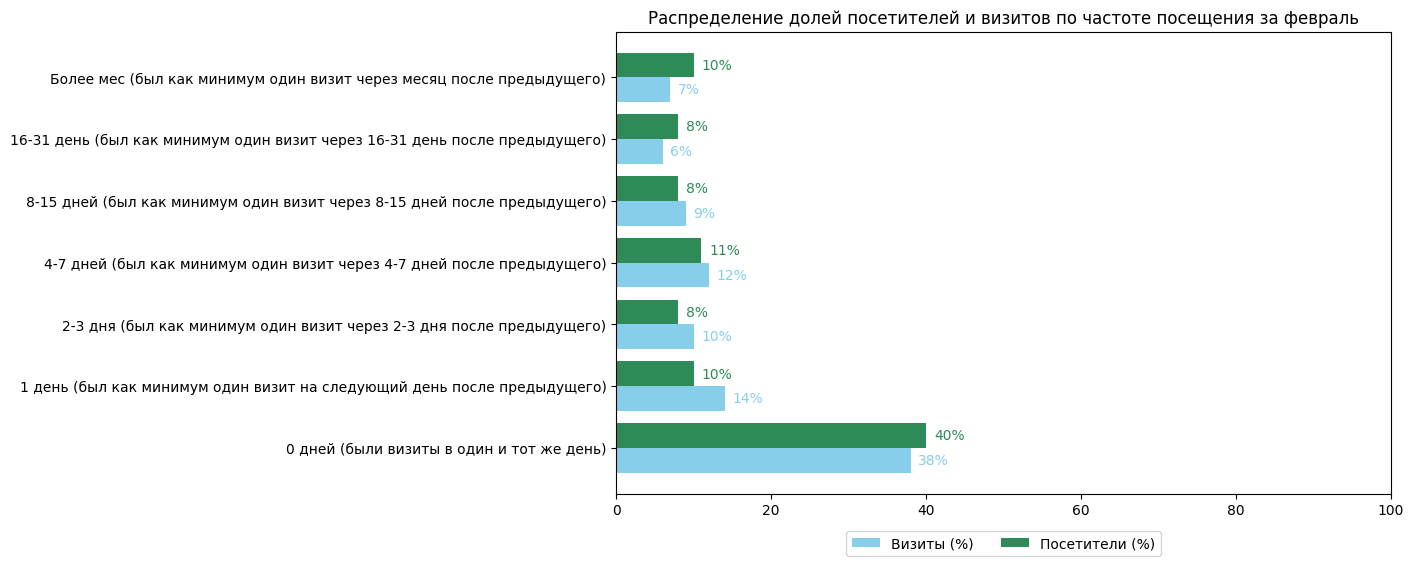

In [22]:
# ГРАФИК периодичность
# Задаем месяц для названия 
report_month = "февраль"
# рисуем график
plt.figure(figsize=(10, 6))

# смещение для столбцов
bar_width = 0.4
y_index = range(len(df_frequency_cut))

plt.yticks(y_index, df_frequency_cut['Периодичность'])
plt.barh([i - bar_width/2 for i in y_index], df_frequency_cut['Визиты (%)'], 
         color='skyblue', height=bar_width, label='Визиты (%)')
plt.barh([i + bar_width/2 for i in y_index], df_frequency_cut['Посетители (%)'], 
         color='seagreen', height=bar_width, label='Посетители (%)')
plt.title(f'Распределение долей посетителей и визитов по частоте посещения за {report_month}')


# Добавляем метки справа от столбцов
for index, value in enumerate(df_frequency_cut['Визиты (%)']):
    plt.text(value + 1, index - bar_width/2, f'{value}%', va='center', color='skyblue')

for index, value in enumerate(df_frequency_cut['Посетители (%)']):
    plt.text(value + 1, index + bar_width/2, f'{value}%', va='center', color='seagreen')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlim(0, 100)  # границы оси X от 0 до 100%
plt.savefig('D:/reports/2025-01/Source_02.25/frequency.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()


           Device type  Users
0  Totals and averages   7786
1          Smartphones   5744
2                   PC   1947
3              Tablets     94
4                   TV      1


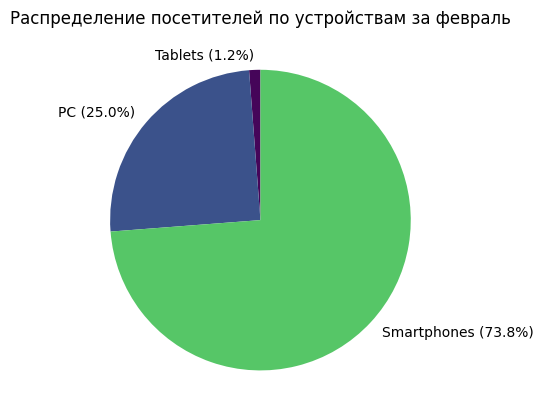

In [23]:
## ТАБЛИЦА Распределение по устройствам (мобильный/немобильный трафик) текущий месяц 
date_from = '2025-02-01'  # Месяц отчета
date_to = '2025-02-28'  
params_device = {
    'date1': date_from,
    'date2': date_to,
    'id': id_cab,
    'metrics': 'ym:s:users',  
    'dimensions': 'ym:s:deviceCategory',  # Группировка по устройствам
    'filters': "ym:s:isRobot=='No'",  
    'accuracy': 1, 
    'attribution': 'lastsign' 
}

# Связка для проверки и создания df
headers = {'Authorization': 'OAuth ' + API_token}
rd = requests.get(API_URL, params=params_device, headers=headers) 

# Проверяем статус ответа
if rd.status_code == 200:
    # Читаем данные в DataFrame
    df_device = pd.read_csv(io.StringIO(rd.text))  
    print(df_device) 
else:
    print("Request failed with status code:", rd.status_code)
    df_device = None

## ГРАФИК Распределение по устройствам (мобильный/немобильный трафик) текущий месяц 
# Удаляем строку "Totals and averages"
df_device = df_device[df_device['Device type'] != 'Totals and averages']
# Преобразуем столбец 'Users' в числовой тип 
df_device['Users'] = pd.to_numeric(df_device['Users'])
# Считаем общую сумму посетителей
total_users = df_device['Users'].sum()
# Считаем доли посетителей в процентах
df_device['Percentage'] = (df_device['Users'] / total_users) * 100
# Удаляем строки, где доля посетителей меньше или равна 1% 
df_device = df_device[df_device['Percentage'] > 1]
# Пересчитываем общую сумму посетителей после удаления малых сегментов
total_users = df_device['Users'].sum()

# Пересчитываем доли посетителей после удаления малых сегментов
df_device['Percentage'] = (df_device['Users'] / total_users) * 100
# Сортируем по убыванию доли для корректного построения пайчарта
df_device = df_device.sort_values('Percentage', ascending=True)

# Создаем подписи для пайчарта
labels = [f"{row['Device type']} ({row['Percentage']:.1f}%)" for index, row in df_device.iterrows()]

# Задаем месяц для названия пайчарта
report_month = "февраль"

# Строим пайчарт
plt.figure(figsize=(5, 5))
# Задаем цветовую гамму (спектр)
colors = plt.cm.viridis(df_device['Percentage'] / 100)  # Используем viridis colormap
#colors = plt.cm.RdYlGn(df_device['Percentage'] / 100)  # Используем RdYlGn colormap
plt.pie(df_device['Percentage'], labels=labels, autopct='', startangle=90, colors=colors) 
plt.title(f'Распределение посетителей по устройствам за {report_month}')
plt.tight_layout()
plt.savefig('D:/reports/2025-01/Source_02.25/devices_1.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

           Device type  Users
0  Totals and averages   7943
1          Smartphones   6016
2                   PC   1832
3              Tablets     95


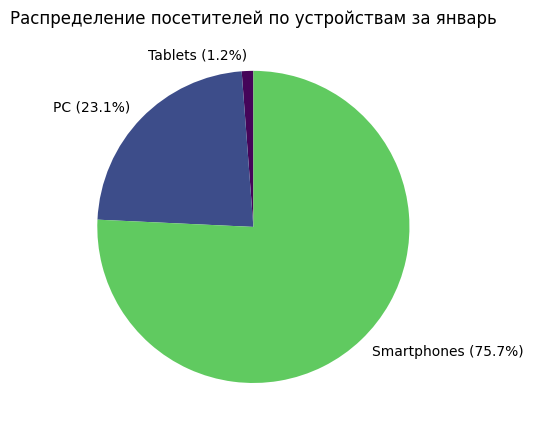

In [24]:
## ТАБЛИЦА Распределение по устройствам (мобильный/немобильный трафик) ПРЕДЫДУЩИЙ месяц 
date_from = '2025-01-01'  # Предыдущий месяц для сравнения с месяцем отчета
date_to = '2025-01-31'  

params_device_pre = {
    'date1': date_from,
    'date2': date_to,
    'id': id_cab,
    'metrics': 'ym:s:users',  
    'dimensions': 'ym:s:deviceCategory',  # Группировка по устройствам
    'filters': "ym:s:isRobot=='No'",  
    'accuracy': 1, 
    'attribution': 'lastsign' 
}

# Связка для проверки и создания df
headers = {'Authorization': 'OAuth ' + API_token}
rdp = requests.get(API_URL, params=params_device_pre, headers=headers) 

# Проверяем статус ответа
if rdp.status_code == 200:
    # Читаем данные в DataFrame
    df_device_pre = pd.read_csv(io.StringIO(rdp.text))  
    print(df_device_pre) 
else:
    print("Request failed with status code:", rdp.status_code)
    df_device_pre = None

## ГРАФИК Распределение по устройствам (мобильный/немобильный трафик) текущий месяц 
# Удаляем строку "Totals and averages"
df_device_pre = df_device_pre[df_device_pre['Device type'] != 'Totals and averages']
# Преобразуем столбец 'Users' в числовой тип данных
df_device_pre['Users'] = pd.to_numeric(df_device_pre['Users'])
# Считаем общую сумму посетителей
total_users = df_device_pre['Users'].sum()
# Считаем доли посетителей в процентах
df_device_pre['Percentage'] = (df_device_pre['Users'] / total_users) * 100
# Удаляем строки, где доля посетителей меньше или равна 1%
df_device_pre = df_device_pre[df_device_pre['Percentage'] > 1]
# Пересчитываем общую сумму посетителей после удаления малых сегментов
total_users = df_device_pre['Users'].sum()
# Пересчитываем доли посетителей после удаления малых сегментов
df_device_pre['Percentage'] = (df_device_pre['Users'] / total_users) * 100
# Сортируем по убыванию доли для корректного построения пайчарта
df_device_pre = df_device_pre.sort_values('Percentage', ascending=True)

# Создаем подписи для пайчарта
labels = [f"{row['Device type']} ({row['Percentage']:.1f}%)" for index, row in df_device_pre.iterrows()]

# Задаем месяц для названия пайчарта
report_month = "январь"

# Строим пайчарт
plt.figure(figsize=(5, 5))
# Задаем цветовую гамму (спектр)
colors = plt.cm.viridis(df_device_pre['Percentage'] / 100)  # Используем viridis colormap
#colors = plt.cm.RdYlGn(df_device_pre['Percentage'] / 100)  # Используем RdYlGn colormap
plt.pie(df_device_pre['Percentage'], labels=labels, autopct='', startangle=90, colors=colors) 
plt.title(f'Распределение посетителей по устройствам за {report_month}')
plt.tight_layout()
plt.savefig('D:/reports/2025-01/Source_02.25/devices_2.png', bbox_inches='tight')  # Сохраняем график с учетом границ
plt.show()

In [ ]:
# СТРАНИЦЫ ВХОДА

# Параметры для отчета по страницам входа
params_entry_pages = {
    'date1': date_from,
    'date2': date_to,
    'id': id_cab,
    'accuracy': 1,
    'attribution': 'lastsign', 
    'dimensions': 'ym:s:startURLPathLevel3',  # группировка по URL 3его уровня
    'metrics': 'ym:s:pageviews, ym:s:users',
    'filters': "ym:s:isRobot=='No' "
}

rs_pages = requests.get(API_URL, params=params_entry_pages, headers={'Authorization': 'OAuth ' + API_token})

if rs_pages.status_code == 200:
    df_entry_pages = pd.read_csv(io.StringIO(rs_pages.text)) 
    # Ограничиваем до топ-20 по количеству посетителей
    df_entry_pages_top20 = df_entry_pages.nlargest(21, 'Users')
else:
    print("Request failed with status code:", rs_pages.status_code)
    df_entry_pages_top20 = None 

print(df_entry_pages_top20)

In [ ]:
# ПОИСКВОВЫЕ ЗАПРОСЫ (ФРАЗЫ) из яндекс поиска

# Параметры для отчета по поисковым фразам
params_search_phrases = {
    'date1': date_from,
    'date2': date_to,
    'id': id_cab,
    'accuracy': 1,
    'attribution': 'lastsign', 
    'dimensions': 'ym:s:lastSearchPhrase',  # группировка по поисковым фразам
    'metrics': 'ym:s:users',
    'filters': "ym:s:isRobot=='No' "
}

rs_search_phrases = requests.get(API_URL, params=params_search_phrases, headers={'Authorization': 'OAuth ' + API_token})

if rs_search_phrases.status_code == 200:
    df_search_phrases = pd.read_csv(io.StringIO(rs_search_phrases.text)) 
    # Ограничиваем до топ-20 по количеству пользователей
    df_search_phrases_top20 = df_search_phrases.nlargest(21, 'Users')
else:
    print("Request failed with status code:", rs_search_phrases.status_code)
    df_search_phrases_top20 = None 

print(df_search_phrases_top20)


In [ ]:
# Отчет ПОПУЛЯРНОЕ - Статьи и глубине просмотра 
# Выставляем даты - период
date_from = '2025-01-01'
date_to = '2025-01-31'

params_view = {
'date1': date_from,
'date2': date_to,
'id': id_cab,
'accuracy': 1,
'dimensions' :'	ym:pv:title',
'metrics': 'ym:pv:pageviews, ym:pv:users',
'filters': "ym:s:isRobot=='No'",
# 'filters': f"ym:pv:URL=*'{url}*'",
'limit': 450
}
rv = requests.get(API_URL, params = params_view, headers={'Authorization': 'OAuth ' + API_token})
# print(rv.text)
if rv.status_code == 200:
    df_view = pd.read_csv(io.StringIO(rv.text))
else:
    print("Request failed with status code:", rv.status_code)

df_view.head()
list_utm = list(df_view['Page title'])

df_view.head(5)


In [ ]:
## Создаем пустой df
scroll_depth = pd.DataFrame({
    "Converted users (Глубина прокрутки 25%)": [],
    "Converted users (Глубина прокрутки 50%)": [],
    "Converted users (Глубина прокрутки 75%)": [],
    "Converted users (Глубина прокрутки 100%)": []
})

In [ ]:
# Цели для параметров из Я.метрики (Профмаркетинг): 
# Глубина прокрутки 25%идентификатор: scroll_depth_25 [[[]]]
# Глубина прокрутки 50%идентификатор: scroll_depth_50 ]]]]
# Глубина прокрутки 75%идентификатор: scroll_depth_75 ]]]]
# Глубина прокрутки 100%идентификатор: scroll_depth_100 ]]]

for url in list_utm: 
    API_URL = '???'
    API_token = '???'

 

    params_depth = {
  
    'date1': date_from,
    'date2': date_to,
    'id': id_cab,
    'accuracy': 1,
    'attribution': 'cross_device_last_significant',
    'metrics': 'ym:s:goalxxxusers, ym:s:goalxxxusers, ym:s:goalxxxusers, ym:s:goalxxxusers', # Цели 
    'filters': "ym:s:isRobot=='No'",
    'filters': f"ym:pv:title=*'{url}*'",
    'limit': 450
    }

    rd = requests.get(API_URL, params = params_depth, headers={'Authorization': 'OAuth ' + API_token})
    print(rd.text)
    
    if rd.status_code == 200:
        temp_df= pd.read_csv(io.StringIO(rd.text))
        scroll_depth = pd.concat([scroll_depth,temp_df], ignore_index=True)
        
        if len(rd.text) == 171 or len(rd.text) == 170:
            # Создаем строку с нулями
            df1 = pd.DataFrame(data=[[0,0,0,0]],columns=["Converted users (Глубина прокрутки 25%)","Converted users (Глубина прокрутки 50%)","Converted users (Глубина прокрутки 75%)","Converted users (Глубина прокрутки 100%)"])
            scroll_depth = pd.concat([scroll_depth,df1], ignore_index=True)
    else:
        print("Request failed with status code:", rd.status_code)

In [ ]:
scroll_depth = scroll_depth.fillna(0)
print(scroll_depth['Converted users (Глубина прокрутки 25%)'].count())
len(list_utm)

In [ ]:
articals_and_goals = pd.concat([df_view, scroll_depth], axis=1)
articals_and_goals = articals_and_goals.reset_index(drop=True)
articals_and_goals

In [ ]:
# Записываем df в Excel
file = f'C:/reports/2025-01/Source_02.25/web_1.xlsx'
dir_name = os.path.dirname(file)
os.makedirs(dir_name, exist_ok=True)

with pd.ExcelWriter(file, engine="openpyxl") as writer:
    df_attendance_1.to_excel(writer, sheet_name='attendance_1')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    merged_df.to_excel(writer, sheet_name=f'attendance_2')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    df_source.to_excel(writer, sheet_name='source_all')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    df_source_merged.to_excel(writer, sheet_name=f'source_segments')  

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    df_mail_traf_filtered.to_excel(writer, sheet_name='mail_traf')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    df_frequency_cut.to_excel(writer, sheet_name='frequency')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    df_device.to_excel(writer, sheet_name='device_1')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    df_entry_pages_top20.to_excel(writer, sheet_name='entry_pages')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    df_search_phrases_top20.to_excel(writer, sheet_name='search_phrases')

with pd.ExcelWriter(file, engine="openpyxl", mode="a") as writer:
    articals_and_goals.to_excel(writer, sheet_name='articals_depth')


print("Основное по отчету готово")

   

Основное по отчету готово
